In [ ]:
# Python 3.6.10
# Pytorch 1.4.0

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 180

Autosaving every 180 seconds


In [3]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
import scipy.io as spio
import torch
import torch.nn as nn
import scipy.interpolate
import torch.optim as optim

In [4]:
# codes taken from https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
            elif isinstance(d[key], np.ndarray):
                d[key] = _tolist(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [10]:
#Model
def f1(v,g):
    if v>0:
        return 1-g
    else:
        return g
def f2(v,w1,w2):
    if v>0:
        return w1
    else:
        return w2
class Model(torch.nn.Module):
    def __init__(self,dt,feedback=True):
        super(Model, self).__init__()
        self.tv = torch.tensor(0.0127)
        self.ty = torch.tensor(0.1649)
        self.w = nn.Parameter(torch.tensor(8.0041))
        self.g1 = torch.tensor(0.0277)
        self.input_scalar1 = torch.tensor(7.6327)
        self.input_scalar2 = torch.tensor(3.7224)
        self.dt = dt
        self.y0 = torch.tensor(0.0) 
        self.outputbias = torch.tensor(0.5348)
        self.outputweights = torch.tensor(0.7417)
        self.feedback=feedback

    def forward(self, sti_y, target):
        res_list=[]
        res_list.append(-target[0])
        v= -target[0]
        y= self.y0 if self.feedback else 0
        for i in range(1,len(sti_y)):
            if self.feedback:
                sti=sti_y[i]*f2(sti_y[i],self.input_scalar1,self.input_scalar2)
                dy=(-y+v*f1(v,torch.clamp(self.g1,0,1)))/self.ty*self.dt
                dv=(-v-self.w*y-sti)/self.tv*self.dt
                v=v+dv
                y=y+dy
            else:
                sti=sti_y[i]*f2(sti_y[i],self.input_scalar1,self.input_scalar2)
                dy=(-y+v*f1(v,torch.clamp(self.g1,0,1)))/self.ty*self.dt
                dv=(-v-self.w*y-sti)/self.tv*self.dt
                v=v+dv
                y=0
            res_list.append(self.outputweights*(v+self.outputbias))
        res_list=torch.stack(res_list)
        return -res_list

In [11]:
res=loadmat('data/L1_CDM_highLum.mat')
mean_res,t=np.array(res['meanResp']),np.array(res['t'])
res2=loadmat('data/L1_CDM_lowLum.mat')
mean_res2,t2=np.array(res2['meanResp']),np.array(res2['t'])

res_o=loadmat('data/L1_highLum.mat')
mean_res_o,t=np.array(res_o['meanResp']),np.array(res_o['t'])
res2_o=loadmat('data/L1_lowLum.mat')
mean_res2_o,t2=np.array(res2_o['meanResp']),np.array(res2_o['t'])

In [12]:
#data preprocessing
mean_sub=np.concatenate([mean_res[1],mean_res[0]]).mean()
std_div=np.concatenate([mean_res[0],mean_res[1]]).std()
mean_res1=mean_res[1]
mean_res1=(mean_res1-mean_sub)/std_div
mean_res2=mean_res[0]
mean_res2=(mean_res2-mean_sub)/std_div
#stimuli
sti_t=t
sti_y1=np.zeros(len(t))
sti_y1[2:5]=1
sti_t=t
sti_y2=np.zeros(len(t))
sti_y2[2:5]=-1
dt=(t[-1]-t[0])/(len(t)-1)

In [15]:
torch.manual_seed(0)
model=Model(dt)
pred=model(sti_y1,torch.from_numpy(mean_res1))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [16]:
for i in range(5000):
    if i==3000:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.2*param_group['lr']
    optimizer.zero_grad()
    loss=0
    pred=model(sti_y1,torch.from_numpy(mean_res1))
    loss+=criterion(pred,torch.from_numpy(mean_res1))
    pred=model(sti_y2,torch.from_numpy(mean_res2))
    loss+=criterion(pred,torch.from_numpy(mean_res2))
    loss.backward()
    optimizer.step()

In [17]:
print(list(model.named_parameters()))

[('w', Parameter containing:
tensor(10.4036, requires_grad=True))]


In [19]:
pred1=model(sti_y1,torch.from_numpy(mean_res1))
pred2=model(sti_y2,torch.from_numpy(mean_res2))
model.w.data.fill_(8.0041)
pred2_o=model(sti_y2,torch.from_numpy(mean_res2))
pred1_o=model(sti_y1,torch.from_numpy(mean_res1))

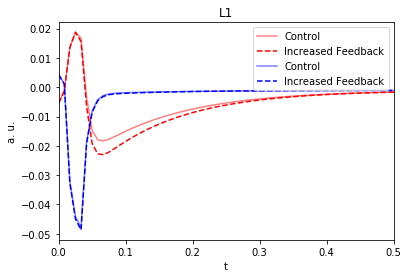

In [20]:
plt.plot(t[:],-(pred2_o.detach().cpu().numpy()*std_div+mean_sub),alpha=.5,label='Control',c='r')
plt.plot(t,-(pred2.detach().cpu().numpy()*std_div+mean_sub),label='Increased Feedback',c='r',linestyle='--')
plt.plot(t[:],-(pred1_o.detach().cpu().numpy()*std_div+mean_sub),alpha=.5,label='Control',c='blue')
plt.plot(t,-(pred1.detach().cpu().numpy()*std_div+mean_sub),label='Increased Feedback',c='blue',linestyle='--')
plt.xlim(0,0.5)
plt.title('L1')
plt.xlabel('t')
plt.ylabel('a. u.')
plt.legend()

In [27]:
res=loadmat('data/L2_CDM_highLum.mat')
mean_res,t=np.array(res['meanResp']),np.array(res['t'])
res2=loadmat('data/L2_CDM_lowLum.mat')
mean_res2,t2=np.array(res2['meanResp']),np.array(res2['t'])
res_o=loadmat('data/L2_highLum.mat')
mean_res_o,t=np.array(res_o['meanResp']),np.array(res_o['t'])
res2_o=loadmat('data/L2_lowLum.mat')
mean_res2_o,t2=np.array(res2_o['meanResp']),np.array(res2_o['t'])

In [31]:
class Model(torch.nn.Module):
    def __init__(self,dt,feedback=True):
        super(Model, self).__init__()
        self.tv = torch.tensor(0.0131)
        self.ty = torch.tensor(0.5613)
        self.w = nn.Parameter(torch.tensor(12.7118))
        self.g1 = torch.tensor(0.1686)  #need double check
        self.input_scalar1 = torch.tensor(5.6441)
        self.input_scalar2 = torch.tensor(3.4075)
        self.dt = dt
        self.y0 = torch.tensor(0.0)
        self.outputbias = torch.tensor(0.2574)
        self.outputweights = torch.tensor(1.0586)
        self.feedback=feedback

    def forward(self, sti_y, target):
        res_list=[]
        res_list.append(-target[0])
        v= -target[0]
        y= self.y0 if self.feedback else 0
        for i in range(1,len(sti_y)):
            if self.feedback:
                sti=sti_y[i]*f2(sti_y[i],self.input_scalar1,self.input_scalar2)
                dy=(-y+v*f1(v,torch.clamp(self.g1,0,1)))/self.ty*self.dt
                dv=(-v-self.w*y-sti)/self.tv*self.dt
                v=v+dv
                y=y+dy
            else:
                sti=sti_y[i]*f2(sti_y[i],self.input_scalar1,self.input_scalar2)
                dy=(-y+v*f1(v,torch.clamp(self.g1,0,1)))/self.ty*self.dt
                dv=(-v-self.w*y-sti)/self.tv*self.dt
                v=v+dv
                y=0
            res_list.append(self.outputweights*(v+self.outputbias))
        res_list=torch.stack(res_list)
        return -res_list

In [32]:
#preprocessing the data
mean_sub=np.concatenate([mean_res[1],mean_res[0]]).mean()
std_div=np.concatenate([mean_res[0],mean_res[1]]).std()
mean_res1=mean_res[1]
mean_res1=(mean_res1-mean_sub)/std_div
mean_res2=mean_res[0]
mean_res2=(mean_res2-mean_sub)/std_div

sti_t=t
sti_y1=np.zeros(len(t))
sti_y1[2:5]=1
sti_t=t
sti_y2=np.zeros(len(t))
sti_y2[2:5]=-1
dt=(t[-1]-t[0])/(len(t)-1)

In [33]:
torch.manual_seed(0)
model=Model(dt)
pred=model(sti_y1,torch.from_numpy(mean_res1))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [34]:
for i in range(5000):
    if i==3000:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.2*param_group['lr']
    optimizer.zero_grad()
    loss=0
    pred=model(sti_y1,torch.from_numpy(mean_res1))
    loss+=criterion(pred,torch.from_numpy(mean_res1))
    pred=model(sti_y2,torch.from_numpy(mean_res2))
    loss+=criterion(pred,torch.from_numpy(mean_res2))
    loss.backward()
    optimizer.step()

In [35]:
print(list(model.named_parameters()))

[('w', Parameter containing:
tensor(23.6371, requires_grad=True))]


In [36]:
pred2=model(sti_y2,torch.from_numpy(mean_res2))
pred1=model(sti_y1,torch.from_numpy(mean_res1))
model.w.data.fill_(12.7118)
pred2_o=model(sti_y2,torch.from_numpy(mean_res2))
pred1_o=model(sti_y1,torch.from_numpy(mean_res1))

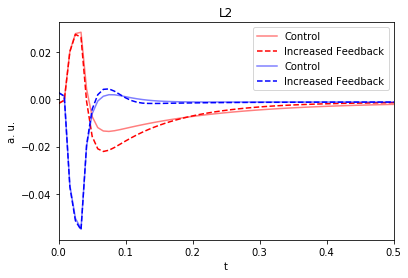

In [37]:
plt.plot(t[:],-(pred2_o.detach().cpu().numpy()*std_div+mean_sub),alpha=.5,label='Control',c='r')
plt.plot(t,-(pred2.detach().cpu().numpy()*std_div+mean_sub),label='Increased Feedback',c='r',linestyle='--')
plt.plot(t[:],-(pred1_o.detach().cpu().numpy()*std_div+mean_sub),alpha=.5,label='Control',c='blue')
plt.plot(t,-(pred1.detach().cpu().numpy()*std_div+mean_sub),label='Increased Feedback',c='blue',linestyle='--')
plt.xlim(0,0.5)
plt.title('L2')
plt.xlabel('t')
plt.ylabel('a. u.')
plt.legend()